In [159]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer

import matplotlib.cm as cm

In [40]:
train = pd.read_csv('data/train.csv.zip', index_col='id')
train.shape

(990, 193)

In [2]:
test = pd.read_csv('data/test.csv.zip', index_col='id')
test.shape

(594, 192)

In [42]:
all_data = pd.concat([train.drop(['species'], axis = 1), test])
all_data.shape

(1584, 192)

In [43]:
tsne = TSNE(n_components=2, init='pca')
x = tsne.fit_transform(scale(all_data))

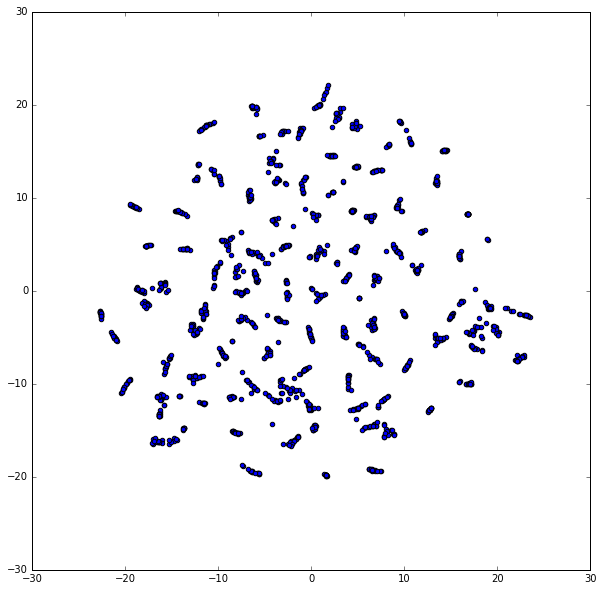

In [44]:
plt.subplots(figsize=(10,10))
plt.scatter(x[:,0], x[:,1])

In [45]:
def draw(x, labels):
    print(silhouette_score(x, labels))
    plt.subplots(figsize=(10,10))
    colors = cm.rainbow(np.linspace(0, 1, len(set(labels))))
    for y_, c in zip(set(labels), colors):
        plt.scatter(x[labels==y_, 0], 
                    x[labels==y_, 1], c=c, alpha=0.5, label=str(y_))

0.765721240767


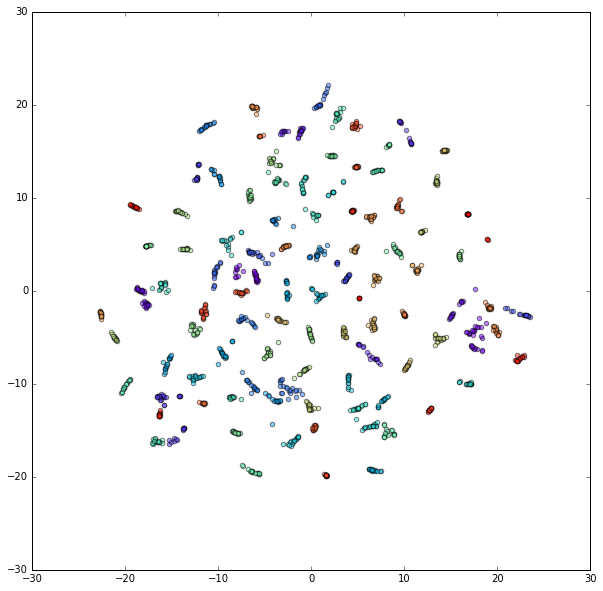

In [46]:
agl_labels = AgglomerativeClustering(n_clusters=99).fit(x).labels_
draw(x, agl_labels)

0.741482537198


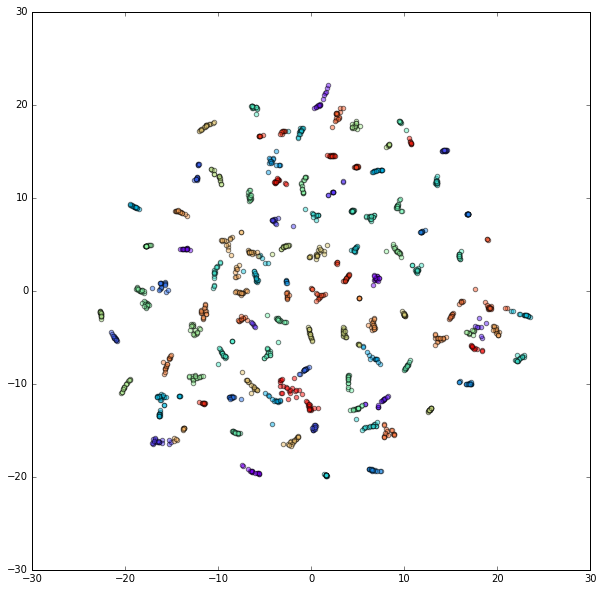

In [47]:
kmeans_labels = MiniBatchKMeans(n_clusters=99).fit(x).labels_
draw(x, kmeans_labels)

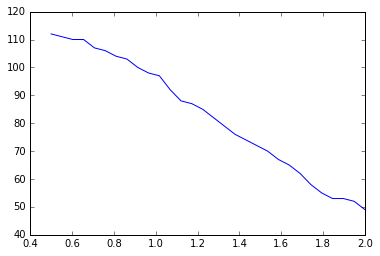

In [49]:
dbscan_eps = []
for n in np.linspace(0.5, 2, 30):
    dbscan_labels = DBSCAN(eps=n,metric='minkowski', p=4).fit(x).labels_
    dbscan_eps.append([n, len(set(dbscan_labels)), silhouette_score(x, dbscan_labels)])
    
dbscan_eps=np.array(dbscan_eps)
plt.plot(dbscan_eps[:,0], dbscan_eps[:,1])

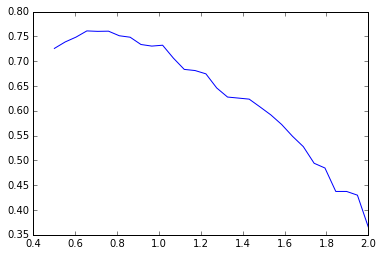

In [50]:
plt.plot(dbscan_eps[:,0], dbscan_eps[:,2])

In [60]:
dbscan_eps[dbscan_eps[:,1] == 98][0][0]

0.96551724137931028

0.729883410742


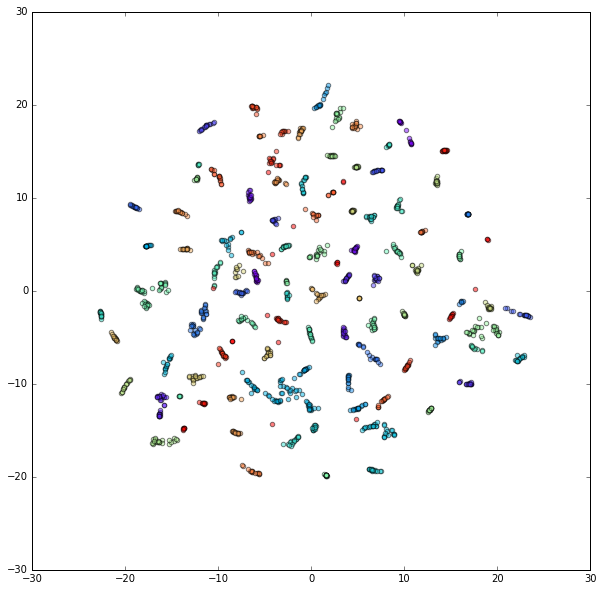

In [61]:
dbscan_labels = DBSCAN(eps=0.96,metric='minkowski', p=4).fit(x).labels_
draw(x, dbscan_labels)

In [81]:
all_clusters = pd.DataFrame(x, index=all_data.index, columns=['x', 'y'])
all_clusters['agl'] = agl_labels
all_clusters['kmeans'] = kmeans_labels
all_clusters['dbscan'] = dbscan_labels
all_clusters.head()

,x,y,agl,kmeans,dbscan
id,,,,,
1,-6.006864,1.553469,0,29,0
2,10.599148,16.139844,6,94,1
3,4.650599,4.547946,72,31,2
5,-6.707199,10.277141,53,50,3
6,3.465871,-4.086626,67,65,4


In [171]:
le = LabelEncoder()
train_x = all_clusters.ix[train.index]
test_x = all_clusters.ix[test.index]
train_y = le.fit_transform(train['species'])

In [95]:
score = cross_val_score(XGBClassifier(n_estimators=300), train_x, train_y, cv=StratifiedKFold(5), scoring='neg_log_loss')
print("{} +-{}".format(score.mean(), score.std()**2))

-0.2788939128178313 +-0.0016116050346440076


In [96]:
score = cross_val_score(XGBClassifier(n_estimators=300), train_x.drop(['x', 'y'],axis=1), train_y, cv=StratifiedKFold(5), scoring='neg_log_loss')
print("{} +-{}".format(score.mean(), score.std()**2))

-0.22177209413488103 +-0.0017242786632168212


In [105]:
score = cross_val_score(KNeighborsClassifier(n_neighbors=9, weights='distance', algorithm='brute'), train_x.drop(['agl', 'kmeans', 'dbscan'],axis=1), train_y, cv=StratifiedKFold(5), scoring='neg_log_loss')
print("{} +-{}".format(score.mean(), score.std()**2))

-0.33315065673965594 +-0.04948006675497083


In [116]:
score = cross_val_score(RandomForestClassifier(n_estimators=2000, max_depth=15), train_x.drop(['x', 'y'],axis=1), train_y, cv=StratifiedKFold(5), scoring='neg_log_loss')
print("{} +-{}".format(score.mean(), score.std()**2))

-0.2797406656024889 +-0.0008108377331108573


In [144]:
def select_xy(X):
    return X[:, [0,1]]

def select_clusters(X):
    return X[:, [2,3,4]]

xgb = Pipeline([
    ('selector', FunctionTransformer(select_clusters)),
    ('clf', XGBClassifier(n_estimators=300))
])

rf = Pipeline([
    ('selector', FunctionTransformer(select_clusters)),
    ('clf', RandomForestClassifier(n_estimators=2000, max_depth=15))
])

knn = Pipeline([
    ('selector', FunctionTransformer(select_xy)),
    ('clf', KNeighborsClassifier(n_neighbors=9, weights='distance', algorithm='brute'))
])

In [162]:
from sklearn.base import BaseEstimator, TransformerMixin

class ModelClassTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model
    def fit(self, *args, **kwargs):
        self.model.fit(*args, **kwargs)
        return self
    def transform(self, X, **transform_params):
        return pd.DataFrame(self.model.predict_proba(X))

In [168]:
clf = VotingClassifier([
        ('xgb', xgb), 
        ('rf', rf), 
        ('knn', knn)
    ], voting='soft')

In [170]:
scores = cross_val_score(clf, train_x, train_y, cv= StratifiedKFold(5), scoring='neg_log_loss')
print("{} +-{}".format(score.mean(), score.std()**2))

-0.33315065673965594 +-0.04948006675497083


In [172]:
clf.fit(train_x, train_y)
pred = clf.predict_proba(test_x)

In [177]:
# 0.14298 on public board

sub = pd.DataFrame(pred, columns=le.classes_, index=test.index)
sub.to_csv('submission/tsne.csv', index_label='id')
sub.head()

,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,Acer_Saccharinum,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
id,,,,,,,,,,,,,,,,,,,,,
4,0.000096,0.000091,0.000278,0.000623,0.000325,0.000159,0.000098,0.003581,0.000089,0.000113,...,0.000146,0.000230,0.000405,0.000197,0.000352,0.000100,0.000109,0.000104,0.000104,0.000637
7,0.000152,0.000834,0.000132,0.000086,0.000293,0.000537,0.000478,0.000099,0.000130,0.001772,...,0.000424,0.000122,0.000045,0.000183,0.000154,0.000349,0.000339,0.001456,0.000281,0.000050
9,0.000211,0.965266,0.000093,0.000068,0.000055,0.000841,0.000130,0.000077,0.000415,0.002649,...,0.000153,0.000096,0.000047,0.000203,0.000234,0.000135,0.000311,0.000116,0.000413,0.000019
12,0.000298,0.000126,0.002775,0.000098,0.000079,0.000155,0.000197,0.000987,0.000231,0.000163,...,0.000153,0.002987,0.000238,0.000616,0.000296,0.000141,0.000434,0.000169,0.000183,0.000042
13,0.001023,0.001365,0.000392,0.000081,0.000075,0.001081,0.000211,0.000300,0.000190,0.001872,...,0.000103,0.000130,0.000134,0.000417,0.000430,0.000176,0.001844,0.000186,0.000140,0.000023
